<a href="https://colab.research.google.com/github/karku4/dataanalysis_strategy/blob/main/DataDrivenStrategy_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Case Study] 유통 데이터를 활용한 전략 수립**
##1.상황 설명
대형 오프라인 마트에 새로운 CEO가 부임
CEO는 데이터분석팀에 다음과 같은 논의사항을 요청하였다
* 회사의 **영업현황 파악**
* 어떤 **카테고리를 확대/축소**할지에 대한 의사결정
* **프로모션 투자의 효율성 검토** 및 향상방향 제언

##2. 데이터 설명
8개의 데이터테이블 
* 거래(영수증데이터)
* 고객 데모
* 상품정보
* 캠페인 테이블
* 캠페인 설명 테이블
* 할인 쿠폰 정보
* 쿠폰 안내(홍보) 정보

https://www.kaggle.com/datasets/frtgnn/dunnhumby-the-complete-journey?resource=download

* 본 노트는 **예시자료로** 빅쿼리로의 데이터 적재 및 스키마 변경 
등의 일부 코드는 생략
* DataStudio를 통한 Dashboard의 경우 산출물로 제시. 자세한 내용은 강의에서 설명진행





# I.영업현황 파악
* case1에 해당하는 전반적 영업동향에 대한 KPI를 작성하고 이를 시각화하여 인사이트를 도출하는 프로세스를 경험한다  
  1. KPI 측정을 위한 데이터 wrangling with python
    * pandas 기반 데이터 결합, 분해, pivoting
    * KPI 의미 파악 및 보정 
  2. 시각화
    * matplotlib 활용
    * Dashboard(DataStudio) 활용
  3. 인사이트 도출

In [ ]:
#데이터 불러오기
import pandas as pd
sql_transaction = '''SELECT * FROM dunhumby.transaction'''
sql_demo = ''' SELECT * FROM dunhumby.hh_demographic'''
sql_product = ''' SELECT * FROM dunhumby.product'''
sql_campaign_table = '''SELECT * FROM dunhumby.campaign_table'''
sql_campaign_desc = '''SELECT * FROM dunhumby.campaing_desc'''
sql_causal = '''SELECT * FROM dunhumby.causal'''
sql_coupon = '''SELECT * FROM dunhumby.coupon'''
sql_coupon_redempt = '''SELECT * FROM dunhumby.coupon_redempt'''
project_id = 'metacodec'

df_transaction = pd.read_gbq(sql_transaction, project_id = project_id, dialect = 'standard') #pandas에서 bigquery에 접근하여 데이터 확인하는 방법
df_demo = pd.read_gbq(sql_demo, project_id = project_id, dialect = 'standard')
df_product = pd.read_gbq(sql_product, project_id = project_id, dialect = 'standard')
df_campaign_tb = pd.read_gbq(sql_campaign_table, project_id = project_id, dialect = 'standard')
df_campaign_desc = pd.read_gbq(sql_campaign_desc, project_id = project_id, dialect = 'standard')
#df_causal = pd.read_gbq(sql_causal, project_id = project_id, dialect = 'standard') #얘 용량이 커서 얘는 별도로 작업
df_coupon = pd.read_gbq(sql_coupon, project_id = project_id, dialect = 'standard')
df_coupon_redempt = pd.read_gbq(sql_coupon_redempt, project_id = project_id, dialect = 'standard')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=qzs1SqxCwv2KvKf1I3V4cGugFBaMQA&access_type=offline
Enter the authorization code: 4/1AWtgzh7P50Brl4MYQdvfUihvNn8kUtj0hQoNp3AYe9wv0Qgk3XsmT8rRaus


##1. 재무현황 파악
* 측정 단위:  월단위 총매출액, 총상품이익, 총프로모션 비용의 합계와 신장률 측정
* 측정 주기: weekly/daily
* 측정 방식:
  * 기존 데이터에 없는 컬럼 추가, 테이블간 결합(join) 
  * groupby&pivot_table 기반 데이터 차원 전환
  * plot 기반 시각화
* 고려사항:
  * 매출액과 상품이익을 별도로 파악하는 것이 효과적인가 
  * 총 프로모션 비용을 어떻게 구할 것인가
  * 결과값에 영향을 주는 외부 요소는 없는가

이하 고려사항을 순차적으로 분석 진행

In [ ]:
df_transaction.info()
#14개의 컬럼으로 구성

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      object 
 1   BASKET_ID          object 
 2   DAY                Int64  
 3   PRODUCT_ID         object 
 4   QUANTITY           Int64  
 5   SALES_VALUE        float64
 6   REGULAR_SALES      float64
 7   CUSTOMER_PAY       float64
 8   STORE_ID           object 
 9   RETAIL_DISC        float64
 10  TRANS_TIME         Int64  
 11  WEEK_NO            Int64  
 12  COUPON_DISC        float64
 13  COUPON_MATCH_DISC  float64
dtypes: Int64(4), float64(6), object(4)
memory usage: 287.2+ MB


In [ ]:
# 1) 주단위 총매출액, 총상품이익, 총 프로모션 비용 변동성 측정
## 방법론
### a. 지표 정의
#### 주단위 총매출액 = sum(REGULAR_SALES) groupby(WEEK_NO)
#### 주단위 총상품이익 = sum(SALES_VALUE) groupby(WEEK_NO)
#### 주단위 총 프로모션비용 = sum(RETAIL_DISC, COUPON_MATCH_DISC) groupby(WEEK_NO)
### b. 변동성: 절대값의 시계열 분포, 직전 주(week) 대비 변화율
### c. groupby& pivot_table 기반 데이터 변환 작업
### d. matplotlib 기반 시각화

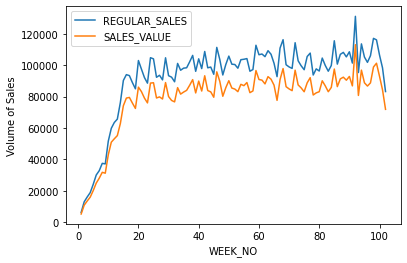

In [ ]:
# 1) 주단위 총매출액, 총상품이익을 별도로 측정하는 것이 맞는가
## 일반적으로 총매출액과 총상품이익은 별개의 값으로 재무적으로 각자 중요하여 각각 측정 및 공시
## 그러나 본 데이터에서는 유통업체가 매입원가를 고려하지 않은 순매출액(프로모션 비용 제외한 매출액)만 있어 총매출과 이익의 중간에 위치하고 있음
## 따라서 유통사 프로모션이 없었을 경우의 정상매출(REGULAR_SALES)과 순매출액을 비교하여 양자간에 매우 유사하다면 KPI는 보다 대표적인 값을 가져가는 것이 타당
## 이를 판단하는 근거로 a. 월별 시계열 분포 b. correlation 값을 보고 의사결정한다

### a.월별 시계열 분포 비교
import matplotlib.pyplot as plt #시각화를 위한 라이브러리 로드
df_transaction.groupby('WEEK_NO')[['REGULAR_SALES','SALES_VALUE']].sum().plot()
# REGULAR_SALES와 SALES_VALUE 값을 WEEK_NO을 단위로 그룹핑하여 합산한 후 그래프를 출력한다 
plt.ylabel('Volume of Sales');
# 그래프를 봤을때는 양자간 추이나 패턴은 유사, 프로모션 비용 차이가 패턴 변화를 유발하지는 않는다 

In [ ]:
### b.correlation 측정
df_transaction[['REGULAR_SALES','SALES_VALUE']].corr(method = 'pearson') #둘다 연속형 변수일 때 사용하는 기본적인 방법
# coefficient :0.96 이것은 동일한 값이라고 판단, 
### 따라서 둘 중에 대표값으로 'SALES_VALUE'를 선택한다. 이유는 영업이익에 보다 직접적인 값이 SALES_VALUE이기 때문

,REGULAR_SALES,SALES_VALUE
REGULAR_SALES,1.000000,0.965579
SALES_VALUE,0.965579,1.000000


In [ ]:
# 2) 총 프로모션 비용 측정
## 총 프로모션 비용은 유통사가 판매진작을 위해 투자한 비용으로,a.RETAIL_DISC(회원고객 할인), b.COUPON_MATCH_DISC(제조사 매칭 투자)로 측정 가능
### 주단위 총 프로모션비용 = sum(RETAIL_DISC, COUPON_MATCH_DISC) groupby(WEEK_NO)
### 또한 REGULAR_SALES - SALES_VALUE 역시 sum(RETAIL_DISC, COUPON_MATCH_DISC)와 동일해야 하는 바, 양자 모두 측정하고 일치하는지 확인 후
###문제가 없다면 컬럼을 transaction에 추가한다
# disc의 값이 음수로 되어 있어 혼란을 줄 수 있음 모두 양수로 변환
df_transaction['RETAIL_DISC'] = df_transaction['RETAIL_DISC'].abs()
df_transaction['COUPON_MATCH_DISC'] = df_transaction['COUPON_MATCH_DISC'].abs()
df_transaction['COUPON_DISC'] = df_transaction['COUPON_DISC'].abs()

df_transaction['promotion_tt'] = df_transaction['RETAIL_DISC'] + df_transaction['COUPON_MATCH_DISC'] #첫번째 방법
df_transaction['promotion_tt2'] = df_transaction['REGULAR_SALES'] - df_transaction['SALES_VALUE'] #두번째 방법
df_transaction[['promotion_tt', 'promotion_tt2']].head() #첫 5개 행의 값은 같음

#DF.equals 메서드 활용:  두 객체가 완벽하게 동일한지를 확인하는 메서드
df_transaction['promotion_tt'].equals(df_transaction['promotion_tt2']) #False? 어딘가 값이 다르다 추적해보자
#아래 방법은 너무 많은 시간을 필요로 한다. 다른식으로 접근하자
#promotion_total =  pd.Series(sum(df_transaction['RETAIL_DISC'],df_transaction['COUPON_MATCH_DISC']))
#promotion_total.head()
# REGULAR_SALES와 SALES_VALUE 값을 WEEK_NO을 단위로 그룹핑하여 합산한 후 그래프를 출력한다 
#df_transaction.info()

False

In [ ]:
 print(df_transaction['promotion_tt'].size);
 print(df_transaction['promotion_tt2'].size)
 check = (df_transaction['promotion_tt'] == df_transaction['promotion_tt2'])
 df_transaction['check'] = check
 df_transaction.head()
 #tt와 tt2가 소수점 2째자리까지는 동일. 아마 floating 데이터 타입 상 덧셈과 뺄셈과정에서 미세한 값 차이를 유발했다고 추정

2595732
2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,REGULAR_SALES,CUSTOMER_PAY,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,promotion_tt,promotion_tt2,check
0,1,27601281299,51,7431134,1,3.99,3.99,3.99,436,0.00,1456,8,0.0,0.0,0.00,0.00,True
1,1,27601281299,51,991024,1,2.50,2.99,2.50,436,0.49,1456,8,0.0,0.0,0.49,0.49,False
2,1,27601281299,51,845307,1,3.71,4.33,3.71,436,0.62,1456,8,0.0,0.0,0.62,0.62,False
3,1,27601281299,51,958046,1,1.59,1.59,1.59,436,0.00,1456,8,0.0,0.0,0.00,0.00,True
4,1,27601281299,51,1074612,2,2.18,2.18,2.18,436,0.00,1456,8,0.0,0.0,0.00,0.00,True


In [ ]:
df_transaction.drop(['promotion_tt2', 'check'], axis = 1, inplace = True) # 열방향으로 promotion_tt2 삭제 후 바로 데이터에 반영
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      object 
 1   BASKET_ID          object 
 2   DAY                Int64  
 3   PRODUCT_ID         object 
 4   QUANTITY           Int64  
 5   SALES_VALUE        float64
 6   REGULAR_SALES      float64
 7   CUSTOMER_PAY       float64
 8   STORE_ID           object 
 9   RETAIL_DISC        float64
 10  TRANS_TIME         Int64  
 11  WEEK_NO            Int64  
 12  COUPON_DISC        float64
 13  COUPON_MATCH_DISC  float64
 14  promotion_tt       float64
dtypes: Int64(4), float64(7), object(4)
memory usage: 307.0+ MB


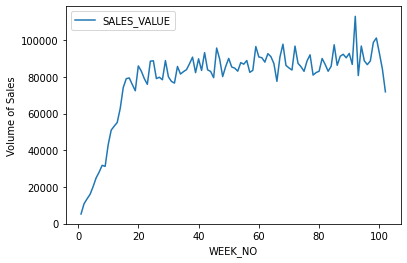

In [ ]:
# 3) 결과값에 영향을 주는 요소는 없는가?
## 재무결과를 판단하는 데 왜곡을 유발하는 요인은 없는지 마지막 검토
df_transaction.groupby('WEEK_NO')[['SALES_VALUE']].sum().plot()
plt.ylabel('Volume of Sales'); #;이거 넣어줘야 y축에 제대로 표시되네
#100일, 20주차 부터 판매 정체기? 아니면 점포 혹은 고객의 영향 때문인지 판단 필요

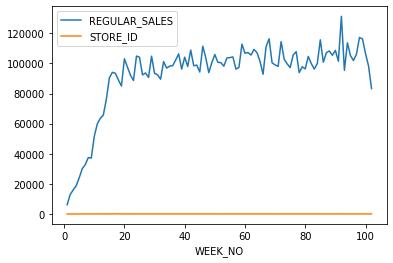

In [ ]:
df_transaction.groupby('WEEK_NO')[['REGULAR_SALES','STORE_ID']].aggregate({'REGULAR_SALES':'sum', 'STORE_ID': pd.Series.nunique}).plot()
#축단위가 맞지 않아 알 수 없음. 보조축 필요

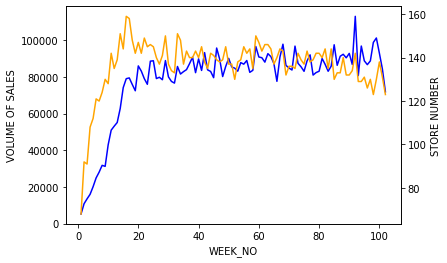

In [ ]:
#보조축(Y)을 통한 그래프 특성 파악

#plt.style.use('default')
#plt.rcParams['figure.figsize'] = (4, 3)
#plt.rcParams['font.size'] = 12
import numpy as np

fig, ax1 = plt.subplots()
ax1.plot(np.sort(df_transaction['WEEK_NO'].unique()), df_transaction.groupby('WEEK_NO')['SALES_VALUE'].sum() , color='blue')
ax1.set_xlabel('WEEK_NO')
ax1.set_ylabel('VOLUME OF SALES')

ax2 = ax1.twinx()
ax2.plot(np.sort(df_transaction['WEEK_NO'].unique()), df_transaction.groupby('WEEK_NO')['STORE_ID'].aggregate(pd.Series.nunique), color='orange')
ax2.set_xlabel('WEEK_NO')
ax2.set_ylabel('STORE NUMBER')

plt.show()
## 16주 차까지 점포수가 비약적으로 증가하면서 매출도 동시에 증가. 점포수가 정체되면서 매출은 유지하는 상황. 즉 점포수에 따른 매출이 큰 영향을 받는 바,
## 점포숫자도 함께 고려하여 확인할 필요가 있음.아니면 최근 점포수가 감소한 특성을 판단함

In [ ]:
# 최종적으로 출력할 재무 실적 요약 테이블 생성
## 아래 테이블은 DataStudio 혹은 엑셀을 통해 Dashboard로 첫번째 페이지로 전달
finance_summary = df_transaction.groupby('WEEK_NO')[['SALES_VALUE','promotion_tt', 'RETAIL_DISC', 'COUPON_MATCH_DISC', 'STORE_ID']].aggregate({'SALES_VALUE': 'sum', 
                                                                                                             'promotion_tt': 'sum',
                                                                                                             'RETAIL_DISC': 'sum',
                                                                                                             'COUPON_MATCH_DISC': 'sum',                                                                                                             
                                                                                                             'STORE_ID': pd.Series.nunique,
                                                                                                             }).reset_index()
print(finance_summary.head())

#매출액 및 프로모션 비용에 대한 신장률 계산
finance_summary['SALES_GROWTH_RATIO'] = finance_summary['SALES_VALUE'].pct_change(periods = 52) #52주, 1년차이를 신장률 정의
finance_summary['PROMOTION_GROWTH_RATIO'] = finance_summary['promotion_tt'].pct_change(periods = 52)
finance_summary.tail()


   WEEK_NO  SALES_VALUE  promotion_tt  RETAIL_DISC  COUPON_MATCH_DISC  \
0        1      5211.16       1040.00      1037.25               2.75   
1        2     10821.35       2152.71      2147.61               5.10   
2        3     13498.20       2560.97      2548.16              12.81   
3        4     15965.99       2894.70      2883.95              10.75   
4        5     20139.82       3982.40      3962.06              20.34   

   STORE_ID  
0        68  
1        92  
2        91  
3       108  
4       112  


,WEEK_NO,SALES_VALUE,promotion_tt,RETAIL_DISC,COUPON_MATCH_DISC,STORE_ID,SALES_GROWTH_RATIO,PROMOTION_GROWTH_RATIO
97,98,98949.62,18273.97,18163.62,110.35,123,0.032036,0.172191
98,99,101363.92,14899.37,14792.27,107.10,130,0.128329,0.071288
99,100,93063.10,13542.02,13457.67,84.35,138,0.158939,-0.002450
100,101,84407.25,14005.66,13917.21,88.45,131,-0.016296,-0.051622
101,102,71968.63,11339.05,11277.80,61.25,123,-0.202296,-0.277535


In [ ]:
finance_summary.to_csv('finance2.csv', mode ='w', index= False)     
#이 테이블에 대한 시각화: 

##2. 고객 파악
* 측정 단위: weekly 고객 수, weekly active(loyal) 고객 수, weekly 프로모션 반응 고객 수,  Basket 지출금액, Basket 구매품목 수, 고객별 구매빈도(주기) 평균, 최근 구매기간(day delta), 구매품목 수의 변동성 파악 측정
* 측정 단위: weekly, hh_id
* 측정 방식:
  * 기존 데이터에 없는 컬럼 추가, 테이블간 결합(join) 
  * groupby&pivot_table 기반 데이터 차원 전환
  * plot 기반 시각화
* 고려사항: 
  * Weekly 기준 구매 고객들의 행태의 시계열 변화 파악
  * active 고객을 어떻게 정의할까
  * 전체 고객의 32%에 해당하는 hh_info를 메타정보로 활용할 것인가? 메타정보가 있는 고객과 없는 고객간의 특성 차이가 유의한지 확인한 후 없다면 활용

이하 고려사항을 순차적으로 분석 진행

In [ ]:
#1) 고객에 대한 view는 2가지로 나눌 수 있다.
## a.기간별 구매 고객의 행태 분석(구매 고객 수, 평균 지출금액, 평균 공헌금액, 평균 구매품목/카테고리 수)
## b.현재까지 파악된 고객들의 분류(유지 고객, 이탈 고객)

### a.Weekly 기준 구매 고객 행태
### WEEK_NO 에서 집계해야 하는 항목은 구매고객 수, 구매장바구니 수, 지출금액 합계, 구매품목 수이다. 여기에 구매품목의 유형을 파악하기 위해 부서, 카테고리 정보를 결합하여 분석을 진행한다.

df_cust_transac = df_transaction[['WEEK_NO','household_key','BASKET_ID','SALES_VALUE','CUSTOMER_PAY', 'PRODUCT_ID' ]] #customer_pay : 고객이 지불한 가격, #SALES_VALUE: 고객지출에 회사에 기여한 이익
df_cust_transac_merge = pd.merge( df_cust_transac, df_product, how = 'left', on = 'PRODUCT_ID')
print(df_cust_transac_merge.head()) #BASKET_ID 취합을 위한 데이터 생성

df_cust_summary = df_cust_transac_merge.groupby(['WEEK_NO','household_key','BASKET_ID'])[['SALES_VALUE', 'CUSTOMER_PAY', 'PRODUCT_ID', 'DEPARTMENT', 
                                              'COMMODITY_DESC', 'SUB_COMMODITY_DESC']].aggregate({'SALES_VALUE' : 'sum',
                                                                                                                                       'CUSTOMER_PAY' : 'sum',
                                                                                                                                       'PRODUCT_ID' : pd.Series.nunique,
                                                                                                                                       'DEPARTMENT' : pd.Series.nunique,
                                                                                                                                       'COMMODITY_DESC' : pd.Series.nunique,
                                                                                                                                       'SUB_COMMODITY_DESC' : pd.Series.nunique
                                                                                                                                       })


   WEEK_NO household_key    BASKET_ID  SALES_VALUE  CUSTOMER_PAY PRODUCT_ID  \
0        8             1  27601281299         3.99          3.99    7431134   
1        8             1  27601281299         2.50          2.50     991024   
2        8             1  27601281299         3.71          3.71     845307   
3        8             1  27601281299         1.59          1.59     958046   
4        8             1  27601281299         2.18          2.18    1074612   

  MANUFACTURER  DEPARTMENT     BRAND             COMMODITY_DESC  \
0          523      PASTRY  National                       PIES   
1         1094  MEAT-PCKGD  National              MISCELLANEOUS   
2         4084        DELI  National                 DELI MEATS   
3          827     GROCERY  National       FRUIT - SHELF STABLE   
4          282     GROCERY  National  VEGETABLES - SHELF STABLE   

        SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          PIES: FRUIT/NUT                       
1                  PIC

In [ ]:
df_cust_summary = df_cust_summary.reset_index()
df_cust_summary.head()
##이 데이터를 기준으로 주차별 구매 고객 수, BASKET 수, 평균 지출금액, 평균 공헌이익, 구매품목 수, 구매카테고리 수를 파악할 수 있음

,WEEK_NO,household_key,BASKET_ID,SALES_VALUE,CUSTOMER_PAY,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC
0,1,1016,27008846527,66.58,66.58,21,5,16,18
1,1,1016,27031018293,83.22,83.22,19,5,15,18
2,1,1060,26985040735,139.22,139.22,50,7,39,45
3,1,1060,27021140059,21.47,21.47,3,1,2,2
4,1,1116,27009291840,39.78,39.78,13,2,10,10


In [ ]:
customer_summary = df_cust_summary.groupby(['WEEK_NO'])[['household_key', 'BASKET_ID', 'SALES_VALUE', 'CUSTOMER_PAY', 'PRODUCT_ID','DEPARTMENT', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC']].aggregate({
    'household_key': pd.Series.nunique,
    'BASKET_ID': 'count',
    'SALES_VALUE': 'mean',
    'CUSTOMER_PAY': 'mean',
    'PRODUCT_ID': 'mean',
    'DEPARTMENT': 'mean',
    'COMMODITY_DESC':'mean',
    'SUB_COMMODITY_DESC':'mean'
}).reset_index()

print(customer_summary.head())
   

   WEEK_NO  household_key  BASKET_ID  SALES_VALUE  CUSTOMER_PAY  PRODUCT_ID  \
0        1             88        142    36.698310     36.580423   13.246479   
1        2            175        324    33.399228     33.332623   11.342593   
2        3            228        482    28.004564     27.841452    9.964730   
3        4            270        545    29.295394     29.152294    9.869725   
4        5            370        757    26.604782     26.494663    9.468956   

   DEPARTMENT  COMMODITY_DESC  SUB_COMMODITY_DESC  
0    2.760563        9.338028           11.204225  
1    2.669753        8.123457            9.469136  
2    2.597510        7.288382            8.520747  
3    2.702752        7.211009            8.330275  
4    2.581242        7.107001            8.114927  


In [ ]:
#2) active 고객 정의: active 고객은 이탈고객의 반대를 의미한다. 구독모델이 아닌 비즈니스의 경우 고객의 명시적인 이탈을 알 수 없는 바,
#이탈여부를  추정하는 로직 혹은 알고리즘이 필요
#이번 분석에서는 현업과 명확한 커뮤니케이션이 가능한 rule기반의 이탈 여부 추정 방식을 적용

#step1  HH_ID기준 고객별 구매빈도(주기) 평균, 최근 구매기간(day delta)
recency = df_transaction['DAY'].max()
df_customer_recency = (recency - df_transaction.groupby('household_key')[['DAY']].max()).reset_index()

In [ ]:
#분포 파악하기
print(df_customer_recency['DAY'].describe());

#이탈여부 추정
#다양한 방식이 있지만 iqr*1.5 + 3사분위 값을 초과하는 경우 outlier로서 이탈했다고 추정 가능
q3 = df_customer_recency['DAY'].quantile(0.75) 
q1 = df_customer_recency['DAY'].quantile(0.25)

iqr = q3 - q1
#고객별 이탈여부 추정하는 함수 및 컬럼 생성
def is_churn(df):
  recency = df['DAY']
  if recency > q3 + 1.5*iqr:
    return True
  else:
    return False
# apply 함수를 통하여 이탈 여부를 찾고 새로운 열에 결과 저장
df_customer_recency['CHURN'] = df_customer_recency.apply(is_churn, axis = 1) # axis = 1 horizontal한 방향으로 데이터를 붙이기
df_customer_recency.rename(columns ={'DAY':'LAST_VISIT'}, inplace= True)
df_customer_recency.sort_values(by = 'LAST_VISIT', ascending = False).head()

count    2500.000000
mean       25.574000
std        62.790655
min         0.000000
25%         1.000000
50%         6.000000
75%        20.000000
max       657.000000
Name: DAY, dtype: float64


,household_key,LAST_VISIT,CHURN
1789,359,657,True
997,1897,642,True
924,1830,642,True
1407,2265,639,True
1337,2201,639,True


In [ ]:
#3) hh_info를 메타정보로 활용할 지의 여부
 #demographic info가 있는 고객ID만 list up
demo_list = df_demo['household_key'].tolist()

 #demo list에 부합하는지 확인하는 함수 정의
def is_demo_available (df):
   household_key = df['household_key']
   if household_key in demo_list:
     return True
   else:
     return False
    
# apply 함수를 통하여 각 값의 이상치 여부를 찾고 새로운 열에 결과 저장
df_cust_summary['demo_info_available'] = df_cust_summary.apply(is_demo_available, axis = 1) # axis = 1 horizontal한 방향으로 데이터를 붙이기
df_cust_summary.head()
df_cust_summary.groupby(['demo_info_available'])['SALES_VALUE', 'CUSTOMER_PAY', 'PRODUCT_ID'].mean()
#TRUE인 경우 SALES_VALUE, CUSTOMER_PAY, PROUDCT_ID(구매상품 품목 수)가 평균적으로 높다. 이에 대해 통계적으로 유의성 여부를 볼 수도 있지만
#이 정도 차이면 demo info 여부가 고객의 활성정도에 편향성(bias)을 준다고 판단할 수 있어, 통계정보로 활용하지 않는 것이 타당 

<ipython-input-19-34b87f557437>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_cust_summary.groupby(['demo_info_available'])['SALES_VALUE', 'CUSTOMER_PAY', 'PRODUCT_ID'].mean()


,SALES_VALUE,CUSTOMER_PAY,PRODUCT_ID
demo_info_available,,,
False,26.146732,26.037582,8.582240
True,32.048940,31.851196,10.170395


In [ ]:
#고객별 최근 구매 도래기간 이탈여부 + 누적구매횟수, 구매주기 merge
customer_snapshot = pd.merge(df_cust_summary, df_customer_recency, on = 'household_key', how = 'left').sort_values(by = 'LAST_VISIT', ascending = False)

In [ ]:
#DataStudio 시각화를 위한 csv 파일 생성
customer_summary.to_csv('customer.csv', mode ='w', index= False)
customer_snapshot.to_csv('customer_snap.csv', mode='w', index=False)

##3. 상품 파악
* 측정 단위: weekly 판매된 상품 수, weekly 상품별 침투율, weekly 상품별 재구매율, Weekly 매출액 top 5상품, Weekly 카테고리별 매출액, 판매된상품/운영상품 비율
* 측정 단위: weekly
* 측정 방식:
  * 기존 데이터에 없는 컬럼 추가, 테이블간 결합(join) 
  * groupby&pivot_table 기반 데이터 차원 전환
  * plot 기반 시각화
* 고려사항: 
  * Weekly 기준 판매된 상품들의 특성(침투율, 재구매율)과 전체 운영상품의 카테고리별 효율성(매출액, 운영상품 대비 판매된 상품)

###A 침투율이란 장바구니 혹은 고객 기준으로 특정 상품(카테고리)이 포함되는 비중을 의미한다.
* 침투율: 개별 장바구니에 해당 상품이 포함될 비율, 즉 100개 장바구니에 10번 해당 상품이 포함되면 침투율은 10%
* 이러한 침투율은 해당상품의 전략적 가치-Loss ledaer 등-를 판단하는 주요 근거로 활용된다


In [ ]:
#1) 우선 weekly 고유 BASKET_ID 갯수 측정
tt_basket_nb = df_transaction.groupby('WEEK_NO')['BASKET_ID'].nunique().reset_index() #주간별 구매 장바구니 수 측정

#2) weekly 침투율 측정
#2)-1 침투율 측정을 위한 데이터 생성
df_basket = df_transaction[['WEEK_NO','BASKET_ID','PRODUCT_ID','REGULAR_SALES','SALES_VALUE']] 
df_basket_merge = pd.merge( df_basket, df_product, how = 'left', on = 'PRODUCT_ID')
print(df_basket_merge.head()) #BASKET_ID 취합을 위한 데이터 생성

df_prdt_summary = df_basket_merge.groupby(['WEEK_NO','PRODUCT_ID', 'DEPARTMENT', 
                                              'COMMODITY_DESC', 'SUB_COMMODITY_DESC'])[['BASKET_ID','REGULAR_SALES','SALES_VALUE' ]].aggregate({'BASKET_ID':pd.Series.nunique,
                                                                                                                                               'REGULAR_SALES': 'sum',
                                                                                                                                               'SALES_VALUE': 'sum'}).reset_index()
df_divison_summary = df_basket_merge.groupby(['WEEK_NO','DEPARTMENT'])['BASKET_ID'].nunique().reset_index()


   WEEK_NO    BASKET_ID PRODUCT_ID  REGULAR_SALES  SALES_VALUE MANUFACTURER  \
0        8  27601281299    7431134           3.99         3.99          523   
1        8  27601281299     991024           2.99         2.50         1094   
2        8  27601281299     845307           4.33         3.71         4084   
3        8  27601281299     958046           1.59         1.59          827   
4        8  27601281299    1074612           2.18         2.18          282   

   DEPARTMENT     BRAND             COMMODITY_DESC       SUB_COMMODITY_DESC  \
0      PASTRY  National                       PIES          PIES: FRUIT/NUT   
1  MEAT-PCKGD  National              MISCELLANEOUS                  PICKLES   
2        DELI  National                 DELI MEATS        MEAT: TURKEY BULK   
3     GROCERY  National       FRUIT - SHELF STABLE                PINEAPPLE   
4     GROCERY  National  VEGETABLES - SHELF STABLE  BEANS GREEN: FS/WHL/CUT   

  CURR_SIZE_OF_PRODUCT  
0                       


In [ ]:
tt_basket_nb.rename(columns = {"BASKET_ID": "TOTAL_NB"}, inplace = True)
tt_basket_nb

,WEEK_NO,TOTAL_NB
0,1,142
1,2,324
2,3,482
3,4,545
4,5,757
...,...,...
97,98,3037
98,99,2851
99,100,2793
100,101,2682


In [ ]:
df_prdt_summary.info()
df_prdt_summary.rename(columns = {'BASKET_ID':'BASKET_NB'}, inplace = True)
df_prdt_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076830 entries, 0 to 1076829
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   WEEK_NO             1076830 non-null  int64  
 1   PRODUCT_ID          1076830 non-null  object 
 2   DEPARTMENT          1076830 non-null  object 
 3   COMMODITY_DESC      1076830 non-null  object 
 4   SUB_COMMODITY_DESC  1076830 non-null  object 
 5   BASKET_ID           1076830 non-null  int64  
 6   REGULAR_SALES       1076830 non-null  float64
 7   SALES_VALUE         1076830 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 65.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076830 entries, 0 to 1076829
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   WEEK_NO             1076830 non-null  int64  
 1   PRODUCT_ID          1076830 non-null  object 

In [ ]:
df_divison_summary.info()
df_divison_summary.rename(columns = {'BASKET_ID':'BASKET_NB'}, inplace = True)
df_divison_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WEEK_NO     2544 non-null   int64 
 1   DEPARTMENT  2544 non-null   object
 2   BASKET_ID   2544 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 59.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WEEK_NO     2544 non-null   int64 
 1   DEPARTMENT  2544 non-null   object
 2   BASKET_NB   2544 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 59.8+ KB


In [ ]:
df_prdt_summary.sort_values(by = 'BASKET_NB', ascending = False).head()
#트로피칼 바나나는 개별 SKU라도 많이 팔린다..

,WEEK_NO,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,BASKET_NB,REGULAR_SALES,SALES_VALUE
998140,96,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,430,475.49,289.76
811298,80,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,397,443.59,301.43
655966,66,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,390,451.30,272.43
439936,47,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,382,421.12,252.70
744243,74,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,381,410.23,330.09


In [ ]:
##개별 PRDT_ID의 weekly 침투율을 계산해보자
penent_wk_prdt = pd.merge(df_prdt_summary,tt_basket_nb, how = 'left', on = 'WEEK_NO')
penent_wk_prdt['PENENTRATION'] = penent_wk_prdt['BASKET_NB']/penent_wk_prdt['TOTAL_NB']
penent_wk_prdt.sort_values(by ='PENENTRATION', ascending = False) #개별 상품별로 침투율을 측정할 필요는 있음

,WEEK_NO,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,BASKET_NB,REGULAR_SALES,SALES_VALUE,TOTAL_NB,PENENTRATION
8347,4,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,89,108.82,86.73,545,0.163303
998140,96,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,430,475.49,289.76,2824,0.152266
1457,1,981760,GROCERY,EGGS,EGGS - X-LARGE,21,47.26,26.10,142,0.147887
290,1,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,20,18.37,18.37,142,0.140845
27815,8,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,150,171.47,102.00,1086,0.138122
...,...,...,...,...,...,...,...,...,...,...
952954,92,13007507,GROCERY,FRZN MEAT/MEAT DINNERS,FRZN MEAT ALTERNATIVES,1,3.79,3.00,3362,0.000297
952953,92,13007435,GROCERY,YOGURT,YOGURT MULTI-PACKS,1,2.49,2.29,3362,0.000297
952950,92,13007358,GROCERY,HOUSEHOLD CLEANG NEEDS,CLEANING WIPES,1,5.49,4.99,3362,0.000297
952949,92,13007353,GROCERY,FRZN BREAKFAST FOODS,FRZN BREAKFAST ENTREES/SANDWIC,1,3.29,2.50,3362,0.000297


In [ ]:
##department 단위 weekly 침투율을 계산해보자
penent_wk_dpt = pd.merge(df_divison_summary, tt_basket_nb, how = 'left', on = 'WEEK_NO')
penent_wk_dpt['PENENTRATION'] = penent_wk_dpt['BASKET_NB']/penent_wk_dpt['TOTAL_NB']
penent_wk_dpt.sort_values(by = 'PENENTRATION', ascending = False)

,WEEK_NO,DEPARTMENT,BASKET_NB,TOTAL_NB,PENENTRATION
6,1,GROCERY,123,142,0.866197
96,5,GROCERY,650,757,0.858653
73,4,GROCERY,458,545,0.840367
119,6,GROCERY,715,861,0.830430
49,3,GROCERY,395,482,0.819502
...,...,...,...,...,...
1640,68,PROD-WHS SALES,1,3283,0.000305
2256,92,AUTOMOTIVE,1,3362,0.000297
2265,92,GARDEN CENTER,1,3362,0.000297
2275,92,PHOTO,1,3362,0.000297


###B 재구매율: 고객이 특정 상품을 다시 구매할 비율. 고객단위로 측정되며 이에 대한 평균값이 해당상품의 재구매율을 의미
* 재구매율을 측정하기 위해서는 1)재구매율 측정 기간단위 정의 2)상품별 구매여부, 재구매여부 정의 3)재구매율 측정 레벨 정의,
* 재구매율 = 재구매인원/(첫구매+재구매인원)로 정의한다

In [ ]:
##1)재구매율 측정기간 정의
###재구매율은 측정기간을 어떻게 하느냐에 따라 그 값이 천양지차이다. 가령 서비스 출시가 5년이상 된 제품의 누적재구매율과, 최근1개월 재구매율을 측정하면 엄청난 차이를 보인다.
###이 때 비즈니스 관점에 필요한 재구매율을 측정하기 위해서는, 비즈니스 구매주기에 비추어 구매주기 내에 재구매가 일어났는지 여부를 판단해야 한다.
###따라서 비즈니스 관점의 재구매주기를 찾고, 이에 대한 적절한  
#고객별 누적구매횟수 및 구매주기
#step1. create unique customer&date, and sort DF by customer&date
df_customer_act = df_transaction[['household_key', 'DAY']].drop_duplicates(keep ='first', inplace = False).sort_values(by=['household_key', 'DAY'], ascending = True)

#create new column that contains difference between days grouped by household_key
df_customer_act['DAY_DIFF']= df_customer_act.groupby(['household_key'])['DAY'].diff()
print(df_customer_act.head())
df_customer_summary = df_customer_act.groupby(['household_key'])['DAY', 'DAY_DIFF'].aggregate({'DAY': 'count',
                                                                             'DAY_DIFF': 'mean'}).reset_index()
df_customer_summary.rename(columns = {'DAY':'PUR_FREQ', 'DAY_DIFF': 'PUR_CYCLE'}, inplace=True)
df_customer_summary.describe()
##구매주기는 평균 17일, 중위값 9일 차지.IQR(Q3-Q1 = 13)*1.5 + Q3(18) = 38.5day를 초과할 경우 구매주기 outlier로 추정할 수 있음
##5week< 38.5 < 6week로 변환하여, 최근 6주이내에 재구매가 일어났는지 여부를 측정 기준으로 수립

   household_key  DAY  DAY_DIFF
0              1   51      <NA>
18             1   67        16
25             1   88        21
33             1   94         6
42             1  101         7


<ipython-input-30-91b9d0a42eef>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customer_summary = df_customer_act.groupby(['household_key'])['DAY', 'DAY_DIFF'].aggregate({'DAY': 'count',


,PUR_FREQ,PUR_CYCLE
count,2500.000000,2497.000000
mean,90.213200,17.030251
std,76.317337,27.769854
min,1.000000,1.248077
25%,34.000000,5.214286
50%,70.000000,9.154930
75%,124.000000,18.222222
max,521.000000,589.000000


In [ ]:
##2) 상품별 고객별 최근 6주이내 재구매율 측정
##data wrangling
#product_id, houdsehold_key, 최근6주내 WEEK_NO 갯수, WEEK_NO_cnt > 1: 재구매인원, WEEK_NO_CNT = 1:첫구매인원, WEEK_NO_CNT= 0:비구매인원
recent_wk = df_cust_transac_merge['WEEK_NO'].max()- 6 #가장 최근 week에서 6주이내 값 계산
prdt_repur_ratio = df_cust_transac_merge[df_cust_transac_merge['WEEK_NO'] > recent_wk].groupby(['PRODUCT_ID','household_key'])['WEEK_NO'].count().reset_index() 
#마스킹으로 데이터를 필터링할때는 국지적 값에 대해 @지정을 해주지 않아도 됨

#재구매여부 정의 함수 및 컬럼 생성
def is_repurchase(df):
  repurchase = df['WEEK_NO']
  if repurchase > 1:
    return 'Re_purchase' 
  else :
    return '1st_purchase'
# apply 함수를 통하여 재구매여부를 찾고 새로운 열에 결과 저장
prdt_repur_ratio['REPUR_IS'] = prdt_repur_ratio.apply(is_repurchase, axis = 1) # axis = 1 horizontal한 방향으로 데이터를 붙이기
prdt_repur = prdt_repur_ratio.pivot_table(values = 'household_key', index = 'PRODUCT_ID', columns = 'REPUR_IS', aggfunc = 'count').fillna(0).reset_index()#최근 6주간 상품별 첫 구매인원 + 재구매인원
prdt_repur['REPUR_RATIO'] = prdt_repur['Re_purchase']/(prdt_repur['Re_purchase']+prdt_repur['1st_purchase'])

prdt_repur.sort_values(by = 'REPUR_RATIO', ascending = False)
#상품별 102주 기준 최근 6주이내 재구매율 측정완료. 평균 재구매율 8%
print(prdt_repur['REPUR_RATIO'].mean())

0.08213368270684793


###C Weekly 매출액 top 5 상품 및 카테고리 확인
* penent_wk_prdt 테이블을 통해 매출액 top5 상품 및 카테고리 확인이 가능

In [ ]:
#매출액 top 5
penent_wk_prdt[(penent_wk_prdt['WEEK_NO']==102)&(penent_wk_prdt['COMMODITY_DESC'] != 'COUPON/MISC ITEMS')].sort_values(by = 'REGULAR_SALES', ascending = False).head()

,WEEK_NO,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,BASKET_NB,REGULAR_SALES,SALES_VALUE,TOTAL_NB,PENENTRATION
1067523,102,1044078,MEAT,BEEF,LEAN,80,572.47,338.06,2383,0.033571
1069805,102,12810391,MEAT,PORK,ENHANCED,15,567.98,257.20,2383,0.006295
1067185,102,1029743,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,151,499.45,490.83,2383,0.063366
1072419,102,8090537,GROCERY,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,62,486.68,264.96,2383,0.026018
1071977,102,6533765,KIOSK-GAS,FUEL,GASOLINE-REG UNLEADED,25,398.08,398.08,2383,0.010491


In [ ]:
#매출액 top 5 카테고리
penent_wk_prdt[(penent_wk_prdt['WEEK_NO']==102)&(penent_wk_prdt['COMMODITY_DESC'] != 'COUPON/MISC ITEMS')].groupby('DEPARTMENT')['REGULAR_SALES'].sum().sort_values(ascending = False)

DEPARTMENT
GROCERY            43556.80
DRUG GM            10106.38
MEAT                5659.41
PRODUCE             5228.00
MEAT-PCKGD          4436.77
DELI                2482.98
NUTRITION           1286.85
SEAFOOD-PCKGD       1125.67
PASTRY              1025.83
COSMETICS            433.51
KIOSK-GAS            398.08
SEAFOOD              346.21
SALAD BAR            320.96
FLORAL               276.45
SPIRITS              203.66
CHEF SHOPPE           53.62
MISC. TRANS.          33.80
TRAVEL & LEISUR       21.16
GARDEN CENTER         18.10
RESTAURANT            13.64
FROZEN GROCERY         7.01
COUP/STR & MFG         3.19
POSTAL CENTER          2.31
TOYS                   0.99
                       0.00
Name: REGULAR_SALES, dtype: float64

In [ ]:
penent_wk_prdt[(penent_wk_prdt['WEEK_NO']==102)&(penent_wk_prdt['COMMODITY_DESC'] != 'COUPON/MISC ITEMS')].groupby('COMMODITY_DESC')['REGULAR_SALES'].sum().sort_values(ascending = False)

COMMODITY_DESC
SOFT DRINKS               4500.18
BEEF                      2756.68
FRZN MEAT/MEAT DINNERS    2109.19
FLUID MILK PRODUCTS       2092.18
CHEESE                    1875.90
                           ...   
NATURAL HBC                  0.99
CHRISTMAS  SEASONAL          0.60
HALLOWEEN                    0.50
FRAGRANCES                   0.00
                             0.00
Name: REGULAR_SALES, Length: 276, dtype: float64

In [ ]:
##appendix.카테고리 층위별 별도 테이블 생성 필요
#penent_wk_ratio.groupby(['WEEK_NO','DEPARTMENT']).aggregate({'BASKET_NB': 'sum', 'TOTAL_NB': 'max'}).sort_values(by = 'BASKET_NB', ascending = False)
#별도의 관점에서 테이블을 생성해야 한다

###D 주차별 판매된 상품 수, 전체운영 상품 중 판매된 상품 수
* 주차별 판매된 상품 수: weekly count raw number
* 전체운영 상품: df_product에 등록된 상품 수
* 판매된 상품수: weekly nunique proudct_id

In [ ]:
#주차별 판매된 상품 수
print(df_transaction.groupby('WEEK_NO')['PRODUCT_ID'].count().reset_index())

#전체운영 상품 수
tt_prdt = df_product['PRODUCT_ID'].count() #92,353개

#주차별 판매된 상품 종류
prdt_transaction = df_transaction.groupby('WEEK_NO')['PRODUCT_ID'].nunique().reset_index()
#주차별 판매상품종류/전체 운영 상품
prdt_transaction['operation_ratio'] = prdt_transaction['PRODUCT_ID'] / tt_prdt
print(prdt_transaction.tail())

#지금까지 누적으로 한번도 판매되지 않은 상품 수
##지금까지 누적으로 판매된 상품 종류
print(df_transaction['PRODUCT_ID'].nunique()) #92,339개, 어쨌든 한번 이상씩은 대부분 판매된 것으로 확인
#102주동안 한번도 판매되지 않은 상품 수: 92,353-92,339 = 14개

     WEEK_NO  PRODUCT_ID
0          1        1881
1          2        3675
2          3        4803
3          4        5379
4          5        7168
..       ...         ...
97        98       31153
98        99       32256
99       100       28902
100      101       26613
101      102       22423

[102 rows x 2 columns]
     WEEK_NO  PRODUCT_ID  operation_ratio
97        98       12067         0.130662
98        99       12277         0.132936
99       100       12009         0.130034
100      101       11137         0.120592
101      102       10320         0.111745
92339


##4. 점포 파악
* 측정 단위: WEEKLY 점포별 매출/이익액, 매출/이익액 신장률, 판매된 상품종류
* 측정 단위: weekly
* 측정 방식:
  * 기존 데이터에 없는 컬럼 추가, 테이블간 결합(join) 
  * groupby&pivot_table 기반 데이터 차원 전환
  * plot 기반 시각화
* 고려사항: 
  * Weekly 기준 점포별로 재무현황 및 operation 효율성을 측정하고 시각화할 수 있는 지표를 찾아본다


In [ ]:
### A.주간 점포별 실적
store_summary = df_transaction.groupby(['WEEK_NO', 'STORE_ID'])[['SALES_VALUE','promotion_tt', 'RETAIL_DISC', 'COUPON_MATCH_DISC', 'PRODUCT_ID']].aggregate({'SALES_VALUE': 'sum', 
                                                                                                             'promotion_tt': 'sum',
                                                                                                             'RETAIL_DISC': 'sum',
                                                                                                             'COUPON_MATCH_DISC': 'sum',                                                                                                             
                                                                                                             'PRODUCT_ID': pd.Series.nunique,
                                                                                                             }).reset_index()
print(store_summary.head())

#매출액 및 프로모션 비용에 대한 신장률 계산
store_summary['SALES_GROWTH_RATIO'] = store_summary.groupby(['STORE_ID','WEEK_NO'])['SALES_VALUE'].pct_change(periods = 52) #52주, 1년차이를 신장률 정의
store_summary['PROMOTION_GROWTH_RATIO'] = store_summary.groupby(['STORE_ID','WEEK_NO'])['promotion_tt'].pct_change(periods = 52)
store_summary.sort_values(by = ['STORE_ID', 'WEEK_NO']).tail(20)
#신장률은 점포별로 102주 연속적으로 판매된 경우가 거의 없어, 점포단위로 측정할 수 없는 상황

print(store_summary.groupby('WEEK_NO')['PRODUCT_ID'].mean()) #PRODUCT_ID로 컬럼명이기는 하나 실제로는 UNIQUE PRODUCT_ID COUNT임으 의미
#점포별 평균 판매된 상품종류가 170정도를 의미. 운영을 어떻게 하는지 모르겠지만 master에 등록된 상품수에 비해 판매된 상품이 극히 적음.
#효율화 필요성 존재

   WEEK_NO STORE_ID  SALES_VALUE  promotion_tt  RETAIL_DISC  \
0        1     2602         5.00          0.98         0.98   
1        1       27        32.59          3.95         3.95   
2        1      286        19.35          1.30         1.30   
3        1      288       113.72         18.80        18.80   
4        1      292        69.54          9.59         9.59   

   COUPON_MATCH_DISC  PRODUCT_ID  
0                0.0           1  
1                0.0          13  
2                0.0           5  
3                0.0          44  
4                0.0          29  
WEEK_NO
1       27.279412
2       39.097826
3       50.879121
4       47.916667
5       61.303571
          ...    
98     230.707317
99     225.884615
100    193.347826
101    186.564885
102    169.926829
Name: PRODUCT_ID, Length: 102, dtype: float64


### 시각화


In [ ]:
###1) 데이터 CSV로 저장
store_summary.to_csv('store.csv', mode ='w', index=False)

** 5주차 Assignment **
*  STORE 현황을 파악할 수 있는 Dashboard 초안을 DataStudio로  만들어주세요. STORE_SUMMARY 파일을 기반으로 작성하시면 됩니다.

In [ ]:
###2)DATA STUDIO에서 점포 특성에 대한 DASHBOARD 초안 작성
# https://datastudio.google.com/reporting/41706c94-f4ff-4ae5-98e4-9e5115300544/page/p_wpsk8hlb2c/edit 참고 


##5. 시각화(Dashboard)
* 최근 시각화의 가장 대표적인 형태는 Dashboard로, 자동화 기능, 인터랙티브(상호반응) 등의 장점이 있어 다양한 산업군에서 널리 사용되고 있음
* 그 중 Bigquery 및 GA(Google Analytics)와의 호환, 무료로서의 강점을 갖고 있는 DataStudio 두각을 나타내고 있음.
* 따라서 본 프로젝트에서도 측정하고자 하는 지표에 대한 wrangling은 python에서, 시각화(Dashboard)는 DataStudio로 진행

In [ ]:
###1) 데이터 CSV로 저장
#주차별 prdt_id 기준의 판매량, 침투율, 구매총액, 카테고리 정보 등 기본적인 정보가 담긴 테이블
penent_wk_prdt.to_csv('penentration.csv', mode ='w', index = False) #모드는 쓰기, 인덱스에는 정보가 없는바 csv로 저장시 제거 

#최근 주차 기준 6주 이내 재구매율
prdt_repur.to_csv('repurchase.csv', mode = 'w', index = False)

#판매된 상품 종류 및 전체 운영상품 중 비중
prdt_transaction.to_csv('product_transaction.csv', mode = 'w', index = False)

In [ ]:
###2)csv로 저장된 파일 local로 다운로드
#파일 클릭 -> 저장된 csv 파일명 클릭 -> 다운로드 클릭 및 로컬 경로 선택

###3)DATA STUDIO 열기
# https://datastudio.google.com/reporting/69c9cd9c-6993-4796-b3dc-93ac88dc33de/page/XnqCD/edit 접속
# 보고서에 데이터 추가 > 데이터 연결 > 파일 업로드 선택
# 로컬에 저장했던 파일 업로드

###4)DATA STUDIO에서 작업 진행
# https://datastudio.google.com/reporting/41706c94-f4ff-4ae5-98e4-9e5115300544/page/p_wpsk8hlb2c/edit 참고 

#II **Category Management** 


## 어떤 카테고리에 효과적인 투자를 할 것인가
제한된 공간과 예산아래 어떤 카테고리의 상품을 확대/축소할지 선택과 집중 필요.
이를 위해 1) 현재 카테고리의 판매 효율성, 2) 미래 성장성을 진단하고
확대/축소 영역을 선택한다

### 1.현재 기준 카테고리의 특성 파악
* 전체 기간 상품이익,침투율 기준: CASH COW VS LOSS LEADER
* 운영 상품 별 매출액 분포:전체기간, 최근 6주 
* 운영 상품 별 프로모션 비용 분포 
* 운영 상품 별 프로모션 비용당 상품이익

### 2.미래 카테고리 성장성 파악
* Weekly 기준 카테고리별 고객수, 상품이익, 프로모션 비용 변화(추세선 파악)

### 3.전략적 선택
* 확대/축소 선택 rule setting

In [ ]:
#1.현재 기준 카테고리 특성 파악
##1) 카테고리 단위 정의
#카테고리의 기준을 DEPARTMENT > COMMODITY_DESC > SUB_COMMODITY_DESC 중 선택한다
#앞서 상품별 현황을 파악하기 위해 생성했던 penent_wk_prdt를 활용해 카테고리 레벨에 따른 매출액 및 카테고리 수를 보고 결정한다
penent_wk_prdt.sort_values(by = 'BASKET_NB', ascending = False).head()

,WEEK_NO,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,BASKET_NB,REGULAR_SALES,SALES_VALUE,TOTAL_NB,PENENTRATION
998140,96,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,430,475.49,289.76,2824,0.152266
811298,80,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,397,443.59,301.43,3006,0.132069
655966,66,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,390,451.30,272.43,2965,0.131535
439936,47,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,382,421.12,252.70,2926,0.130554
744243,74,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,381,410.23,330.09,2999,0.127042


In [ ]:
#카테고리 단위별 매출액 집계
##A DEPARTMENT 기준
print(penent_wk_prdt.groupby('DEPARTMENT')['SALES_VALUE'].sum().sort_values(ascending = False).reset_index()) #43개 카테고리, 하지만 GROCERY가 전체매출의 50%를 차지
print(penent_wk_prdt['SALES_VALUE'].sum()) #총 매출이익은 8,057,463

##B COMMODITY_DESC 기준
print(penent_wk_prdt.groupby('COMMODITY_DESC')['SALES_VALUE'].sum().sort_values(ascending = False).reset_index()) #308개 카테고리, 쿠폰과 기타유형이 가장 큰 매출액 차지

##C SUB_COMMODITY_DESC 기준
print(penent_wk_prdt.groupby('SUB_COMMODITY_DESC')['SALES_VALUE'].sum().sort_values(ascending = False).reset_index()) #2,383개 카테고리, 카테고리의 용량도 함께 표기되어 있음


         DEPARTMENT  SALES_VALUE
0           GROCERY   4093814.14
1           DRUG GM   1055358.03
2           PRODUCE    557452.11
3              MEAT    548786.81
4         KIOSK-GAS    544222.28
5        MEAT-PCKGD    412436.77
6              DELI    260866.51
7            PASTRY    121739.86
8   MISC SALES TRAN    119960.04
9         NUTRITION     97669.04
10    SEAFOOD-PCKGD     63093.62
11           FLORAL     39653.34
12        COSMETICS     32360.37
13        SALAD BAR     30953.30
14          SEAFOOD     29496.92
15          SPIRITS     21670.88
16     MISC. TRANS.     10678.69
17    GARDEN CENTER      7667.82
18  TRAVEL & LEISUR      2550.38
19      CHEF SHOPPE      2290.80
20       RESTAURANT      1986.76
21   COUP/STR & MFG      1027.72
22   FROZEN GROCERY       653.26
23       AUTOMOTIVE       452.66
24               RX       159.56
25     GM MERCH EXP       101.10
26       DAIRY DELI        73.23
27  CNTRL/STORE SUP        49.05
28            PHOTO        41.40
29   DELI/

**따라서 이러한 구조를 볼 때 COMMODITY_DESC를 카테고리 기준으로 보는 것이 타당**

In [ ]:
#크게 2개의 원천 테이블 조합을 통해 분석용 데이터마트 생성
#1)거래데이터 기준
###) WEEK_NO, PRODUCT_ID그룹 기준: 구매고객 수, 장바구니 수, 판매된 SKU 종류, 판매수량(sum QUANTITY), 상품이익, 매출액, 총 프로모션 비용 
###) 주차별 판매정보 aggregation 기준
commodity_wk_desc = df_transaction.groupby(['WEEK_NO', 'PRODUCT_ID'])['household_key', 'BASKET_ID', 'QUANTITY','SALES_VALUE', 'REGULAR_SALES', 'promotion_tt'].aggregate({
    'household_key': pd.Series.nunique,
    'BASKET_ID': pd.Series.nunique,    
    'QUANTITY' : 'sum',
    'SALES_VALUE': 'sum',
    'REGULAR_SALES': 'sum',
    'promotion_tt': 'sum'
}).reset_index()
 
##해석을 위한 컬럼명 변경
commodity_wk_desc.rename(columns = {'household_key':'CUST_NB','BASKET_ID':'BASKET_NB'}, inplace= True)
commodity_wk_desc.head()

<ipython-input-42-bbc9cf6a9e7e>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  commodity_wk_desc = df_transaction.groupby(['WEEK_NO', 'PRODUCT_ID'])['household_key', 'BASKET_ID', 'QUANTITY','SALES_VALUE', 'REGULAR_SALES', 'promotion_tt'].aggregate({


,WEEK_NO,PRODUCT_ID,CUST_NB,BASKET_NB,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt
0,1,1000341,1,1,2,3.00,3.98,0.98
1,1,1000493,1,1,1,4.44,5.33,0.89
2,1,1000753,1,1,3,9.97,13.97,4.00
3,1,1000970,1,1,1,1.29,1.29,0.00
4,1,1001148,1,1,3,2.97,2.97,0.00


In [ ]:
#1)-1 침투율 계산을 위한 주차별 총 판매 장바구니 측정
total_basket_nb = df_transaction.groupby('WEEK_NO')['BASKET_ID'].nunique().reset_index()
commodity_wk_desc = pd.merge(commodity_wk_desc, total_basket_nb, how = 'left', on = 'WEEK_NO')
commodity_wk_desc.tail()

,WEEK_NO,PRODUCT_ID,CUST_NB,BASKET_NB,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt,BASKET_ID
1076825,102,999858,4,4,4,15.27,15.27,0.00,2383
1076826,102,999891,1,1,2,3.38,4.98,1.60,2383
1076827,102,999913,1,1,1,1.99,1.99,0.00,2383
1076828,102,999965,1,1,1,3.49,3.49,0.00,2383
1076829,102,999971,17,18,23,22.88,29.67,6.79,2383


In [ ]:
#2) 상품마스터 결합
#)commodity_desc 기준으로 취합
commodity_wk_desc = pd.merge( commodity_wk_desc, df_product, how = 'left', on = 'PRODUCT_ID')
#)week_no, commodity_desc의 group_by를 기준으로 판매된 SKU 종류 prodduct_id:nunique(), 총 판매된 SKU 수 SUM: BASKET_NB, 주간 총판매 장바구니 수 MAX:TOTAL_NB, 
#)총 상품이익 SUM:SALES_VALUE, 총 매출액 SUM: REGULAR_SALES, 총 프로모션비용 SUM: promotion_tt
commodity_wk_desc.head()

,WEEK_NO,PRODUCT_ID,CUST_NB,BASKET_NB,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt,BASKET_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1,1000341,1,1,2,3.00,3.98,0.98,142,5093,GROCERY,National,MISC. DAIRY,REFRIGERATED MEXICAN PRODUCTS,24 OZ
1,1,1000493,1,1,1,4.44,5.33,0.89,142,4112,DELI,National,PREPARED FOOD,PREP FD: ENTREES (COLD),
2,1,1000753,1,1,3,9.97,13.97,4.00,142,2822,MEAT,National,BEEF,SELECT BEEF,
3,1,1000970,1,1,1,1.29,1.29,0.00,142,69,GROCERY,Private,REFRGRATD DOUGH PRODUCTS,REFRIGERATED BAGELS,14.25 OZ
4,1,1001148,1,1,3,2.97,2.97,0.00,142,69,MEAT-PCKGD,Private,LUNCHMEAT,BOLOGNA,16 OZ


In [ ]:
commodity_wk = commodity_wk_desc.groupby(['WEEK_NO','DEPARTMENT','COMMODITY_DESC'])['PRODUCT_ID', 'CUST_NB','BASKET_NB', 'BASKET_ID', 'QUANTITY','SALES_VALUE', 'REGULAR_SALES', 'promotion_tt'].aggregate({
    'PRODUCT_ID':pd.Series.nunique,
    'CUST_NB': 'sum',
    'BASKET_NB': 'sum',
    'BASKET_ID':'max',
    'QUANTITY':'sum',
    'SALES_VALUE':'sum',
    'REGULAR_SALES': 'sum',
    'promotion_tt' : 'sum'
}).reset_index() #department는 메타정보로 활용만 할뿐, 그룹핑 기준으로 사용하지 않음
commodity_wk.loc[commodity_wk['DEPARTMENT'].str.startswith(' '), 'DEPARTMENT'] = 'PRIVATE_LABEL' # 공란은 PB 상품으로 확인한 바 정보 업뎃
commodity_wk.loc[commodity_wk['COMMODITY_DESC'].str.startswith(' '), 'COMMODITY_DESC'] = 'PRIVATE_LABEL' # 공란은 PB 상품으로 확인한 바 정보 업뎃
commodity_wk.head()

<ipython-input-45-f03d37d75910>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  commodity_wk = commodity_wk_desc.groupby(['WEEK_NO','DEPARTMENT','COMMODITY_DESC'])['PRODUCT_ID', 'CUST_NB','BASKET_NB', 'BASKET_ID', 'QUANTITY','SALES_VALUE', 'REGULAR_SALES', 'promotion_tt'].aggregate({


,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,CUST_NB,BASKET_NB,BASKET_ID,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt
0,1,PRIVATE_LABEL,PRIVATE_LABEL,2,5,5,142,0,0.00,0.00,0.00
1,1,AUTOMOTIVE,COUPON,1,1,1,142,1,4.99,4.99,0.00
2,1,COSMETICS,BATH,1,1,1,142,1,4.99,4.99,0.00
3,1,COSMETICS,MAKEUP AND TREATMENT,1,1,1,142,1,3.49,3.49,0.00
4,1,DELI,CHEESES,11,11,11,142,11,47.72,50.39,2.67


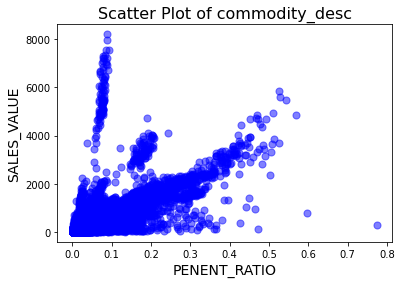

In [ ]:
#3) COMMODITY_DESC의 침투율 계산
#주간별 침투율을 COMMODITY_DESC 기준으로 측정
commodity_wk['PENENT_RATIO'] = commodity_wk['BASKET_NB']/commodity_wk['BASKET_ID'] #주간별 침투율
commodity_wk.sort_values(by = 'PENENT_RATIO', ascending = False)
#시각화
commodity_wk.plot.scatter(x = 'PENENT_RATIO',
                                 y = 'SALES_VALUE',
                                 s = 50, #market size
                                 c= 'blue',
                                 alpha= 0.5)
plt.title('Scatter Plot of commodity_desc', fontsize=16)
plt.xlabel('PENENT_RATIO', fontsize=14)
plt.ylabel('SALES_VALUE', fontsize=14)
plt.show()

In [ ]:
#4)카테고리별 운영 상품수 계산
##a)df_product에서 commodity_desc 기준 데이터: 운영 상품 수 : OP_SKU_NB로 정의
category_info = df_product.groupby('COMMODITY_DESC')['PRODUCT_ID'].nunique().reset_index()
#COMMODITY_DESC가 비어있는 상품: Private Brand로 파악
category_info.rename(columns = {'PRODUCT_ID':'OP_SKU_NB'}, inplace = True)
category_info.loc[category_info['COMMODITY_DESC'].str.startswith(' '),'COMMODITY_DESC'] = 'PRIVATE_LABEL'
category_info.sort_values(by = 'OP_SKU_NB', ascending = True)

,COMMODITY_DESC,OP_SKU_NB
33,BOUQUET (NON ROSE),1
197,MISCELLANEOUS CROUTONS,1
228,PKG.SEAFOOD MISC,1
132,FROZEN PACKAGE MEAT,1
199,MISCELLANEOUS(CORP USE ONLY),1
...,...,...
273,SOFT DRINKS,1704
153,HAIR CARE PRODUCTS,1744
187,MAKEUP AND TREATMENT,2467
44,CANDY - PACKAGED,2475


In [ ]:
#5)운영상품 정보와 매출/프로모션 정보 결합 
category_merge = pd.merge(commodity_wk, category_info, how = 'left',on = 'COMMODITY_DESC')
category_merge.head(3)

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,CUST_NB,BASKET_NB,BASKET_ID,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt,PENENT_RATIO,OP_SKU_NB
0,1,PRIVATE_LABEL,PRIVATE_LABEL,2,5,5,142,0,0.00,0.00,0.0,0.035211,15
1,1,AUTOMOTIVE,COUPON,1,1,1,142,1,4.99,4.99,0.0,0.007042,3
2,1,COSMETICS,BATH,1,1,1,142,1,4.99,4.99,0.0,0.007042,383


In [ ]:
#6)상품이익 집중도 컬럼 추가 pareto ratio 기준으로 상위 80% 매출을 몇개의 SKU가 점유하는지 계산한다
#매출이 특정 상품에 얼마나 집중되어 있는지는 해당 카테고리의 안정성, 전략적 leverage 가능 정도 등에 큰 영향을 준다
#a)commodity_desc, wk별 prdt의 상품이익 점유율를 측정해야한다
#b)측정한 점유율의 누적합을 계산한다
#c)a를 기준으로 내림차순한다
#d)80% 분위에 해당하는 위치(SKU 수)를 반환한다(python은 idx가 0부터 시작, so +1 필요)

In [ ]:
#a)commodity_desc, wk별 prdt의 상품이익 점유율를 측정해야한다

def SALES_PROP(group):
  group['PROP'] = group.SALES_VALUE / group.SALES_VALUE.sum()
  return group

commodity_sale = commodity_wk_desc.groupby(['WEEK_NO','DEPARTMENT', 'COMMODITY_DESC'])['WEEK_NO','DEPARTMENT','COMMODITY_DESC','PRODUCT_ID','SALES_VALUE'].apply(SALES_PROP)
commodity_sale.head()

<ipython-input-50-24f8e46d94fe>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  commodity_sale = commodity_wk_desc.groupby(['WEEK_NO','DEPARTMENT', 'COMMODITY_DESC'])['WEEK_NO','DEPARTMENT','COMMODITY_DESC','PRODUCT_ID','SALES_VALUE'].apply(SALES_PROP)


,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,SALES_VALUE,PROP
0,1,GROCERY,MISC. DAIRY,1000341,3.00,0.216450
1,1,DELI,PREPARED FOOD,1000493,4.44,0.311579
2,1,MEAT,BEEF,1000753,9.97,0.053100
3,1,GROCERY,REFRGRATD DOUGH PRODUCTS,1000970,1.29,0.059889
4,1,MEAT-PCKGD,LUNCHMEAT,1001148,2.97,0.050305


In [ ]:
#b)측정한 점유율의 누적합을 계산한다
def SALES_CUMPROP(df):
  df['CUMPROP'] = df.sort_values(by = 'PROP', ascending= False)['PROP'].cumsum()
  return df

In [ ]:
commodity_sale = commodity_sale.groupby(['WEEK_NO','DEPARTMENT', 'COMMODITY_DESC']).apply(SALES_CUMPROP)
commodity_sale.head()

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,SALES_VALUE,PROP,CUMPROP
0,1,GROCERY,MISC. DAIRY,1000341,3.00,0.216450,0.216450
1,1,DELI,PREPARED FOOD,1000493,4.44,0.311579,0.741754
2,1,MEAT,BEEF,1000753,9.97,0.053100,0.627397
3,1,GROCERY,REFRGRATD DOUGH PRODUCTS,1000970,1.29,0.059889,1.000000
4,1,MEAT-PCKGD,LUNCHMEAT,1001148,2.97,0.050305,0.655827


In [ ]:
#d)80% 분위에 해당하는 위치(SKU 수)를 반환한다(python은 idx가 0부터 시작, so +1 필요)
## pandas.Series.searchsorted
## Series.searchsorted(value, side='left', sorter=None)[source]
## Find indices where elements should be inserted to maintain order.

def quantile_idx(group, p= 0.8):
    group = group.sort_values(by='CUMPROP', ascending=True)
    return group['CUMPROP'].searchsorted(p) + 1
 
## getting the index of quantile p=0.8 by group
commodity_sale_concentration = commodity_sale.groupby(['WEEK_NO','DEPARTMENT','COMMODITY_DESC']).apply(quantile_idx, p=0.8)

In [ ]:
#commodity_sale_concentration.info() #series 인지, dataframe인지 확인하기 위해 실행

In [ ]:
commodity_sale_concentration = commodity_sale_concentration.to_frame() # series를 df로 변환
commodity_sale_concentration.reset_index(inplace = True)
commodity_sale_concentration.tail()

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,0
28754,102,SEAFOOD-PCKGD,SEAFOOD - MISC,9
28755,102,SEAFOOD-PCKGD,SEAFOOD-FRESH,5
28756,102,SPIRITS,LIQUOR,11
28757,102,TOYS,TOYS,1
28758,102,TRAVEL & LEISUR,APPLES,1


In [ ]:
commodity_sale_concentration.rename(columns = {0:'80%_idx'}, inplace = True)
commodity_sale_concentration.loc[commodity_sale_concentration['DEPARTMENT'].str.startswith(' '),'DEPARTMENT'] = 'PRIVATE_LABEL'
commodity_sale_concentration.loc[commodity_sale_concentration['COMMODITY_DESC'].str.startswith(' '),'COMMODITY_DESC'] = 'PRIVATE_LABEL'
commodity_sale_concentration.head()

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,80%_idx
0,1,PRIVATE_LABEL,PRIVATE_LABEL,1
1,1,AUTOMOTIVE,COUPON,1
2,1,COSMETICS,BATH,1
3,1,COSMETICS,MAKEUP AND TREATMENT,1
4,1,DELI,CHEESES,7


In [ ]:
#주차별 카테고리 80%분위수와 기존 카테고리 정보 결합
category_merge_v2 = pd.merge(category_merge, commodity_sale_concentration, how = 'left',on = ['WEEK_NO','DEPARTMENT','COMMODITY_DESC'])
#category_merge_v2.loc[category_merge_v2['DEPARTMENT'].str.startswith(' '),'DEPARTMENT'] = 'PRIVATE_LABEL'
#category_merge_v2.loc[category_merge_v2['COMMODITY_DESC'].str.startswith(' '),'COMMODITY_DESC'] = 'PRIVATE_LABEL'
category_merge_v2.head()

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,CUST_NB,BASKET_NB,BASKET_ID,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt,PENENT_RATIO,OP_SKU_NB,80%_idx
0,1,PRIVATE_LABEL,PRIVATE_LABEL,2,5,5,142,0,0.00,0.00,0.00,0.035211,15,1
1,1,AUTOMOTIVE,COUPON,1,1,1,142,1,4.99,4.99,0.00,0.007042,3,1
2,1,COSMETICS,BATH,1,1,1,142,1,4.99,4.99,0.00,0.007042,383,1
3,1,COSMETICS,MAKEUP AND TREATMENT,1,1,1,142,1,3.49,3.49,0.00,0.007042,2467,1
4,1,DELI,CHEESES,11,11,11,142,11,47.72,50.39,2.67,0.077465,743,7


In [ ]:
# 2.미래 카테고리 성장성 파악
### Weekly 기준 카테고리별 고객수, 상품이익, 프로모션 비용 변화(추세선 파악)
### 성장률은 전주 대비로 파악. 신장률과 비교한 이유는 시계열의 연속선상에서 어떻게 변화하는지를 판단하는 것이 보다 타당하다고 생각

In [ ]:
#고객수 , 상품이익, 프로모션 비용에 대한 성장률 계산
category_merge_v2['SALES_variation'] = category_merge_v2.sort_values('WEEK_NO').groupby('COMMODITY_DESC')['SALES_VALUE'].pct_change(periods = 1, fill_method='bfill') #1주차이를 성장률 정의.따라서 2주차부터 측정 가능
category_merge_v2['CUST_NB_variation'] = category_merge_v2.sort_values('WEEK_NO').groupby('COMMODITY_DESC')['CUST_NB'].pct_change(periods = 1, fill_method='bfill')
category_merge_v2['COST_variation'] = category_merge_v2.sort_values('WEEK_NO').groupby('COMMODITY_DESC')['promotion_tt'].pct_change(periods = 1, fill_method='bfill')

category_merge_v2[category_merge_v2['COMMODITY_DESC']=='BACON']

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,CUST_NB,BASKET_NB,BASKET_ID,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt,PENENT_RATIO,OP_SKU_NB,80%_idx,SALES_variation,CUST_NB_variation,COST_variation
144,1,MEAT-PCKGD,BACON,9,10,10,142,13,45.57,52.34,6.77,0.070423,168,7,NaN,NaN,NaN
367,2,MEAT-PCKGD,BACON,9,11,12,324,17,63.30,70.23,6.93,0.037037,168,6,0.389072,0.100000,0.023634
615,3,MEAT-PCKGD,BACON,10,16,16,482,24,66.66,94.97,28.31,0.033195,168,6,0.053081,0.454545,3.085137
862,4,MEAT-PCKGD,BACON,13,20,20,545,24,78.19,92.46,14.27,0.036697,168,8,0.172967,0.250000,-0.495938
1117,5,MEAT-PCKGD,BACON,18,35,35,757,49,145.28,202.43,57.15,0.046235,168,10,0.858038,0.750000,3.004905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27519,98,MEAT-PCKGD,BACON,27,131,134,3037,190,568.87,741.60,172.73,0.044122,168,13,0.190802,0.110169,-0.273939
27811,99,MEAT-PCKGD,BACON,35,167,169,2851,229,680.77,890.95,210.18,0.059277,168,15,0.196706,0.274809,0.216812
28107,100,MEAT-PCKGD,BACON,36,124,127,2793,179,524.54,722.72,198.18,0.045471,168,16,-0.229490,-0.257485,-0.057094
28388,101,MEAT-PCKGD,BACON,32,130,132,2682,179,529.17,700.35,171.18,0.049217,168,15,0.008827,0.048387,-0.136240


In [ ]:
category_merge_v2['SALES_variation'].value_counts()
#카테고리별로 판매량이 아예 없는 기간이 존재하는 등, NAN, inf처럼 증감률로 측정하기 적당하지 경우가 상당 수 존재
#따라서 비율의 증감이 아닌 실제 값의 차이(이번주차 - 직전주차)로 delta를 측정하는 것이 타당
#실제값으로 사용할 경우, 정규화가 아닌 해당 단위값에 영향을 받으나 모두가 동일한 단위(금액, 개수)를 사용한다는 점에서 문제가 적다고 판단

 0.000000    162
-0.500000     48
 inf          48
-1.000000     47
 1.000000     44
            ... 
-0.640336      1
 0.591421      1
 2.320720      1
 0.808404      1
-0.943156      1
Name: SALES_variation, Length: 27797, dtype: int64

In [ ]:
#고객수 , 상품이익, 프로모션 비용에 대한 변화폭 계산
category_merge_v2['SALES_variation'] = category_merge_v2.sort_values('WEEK_NO').groupby('COMMODITY_DESC')['SALES_VALUE'].diff(periods = 1) 
category_merge_v2['CUST_NB_variation'] = category_merge_v2.sort_values('WEEK_NO').groupby('COMMODITY_DESC')['CUST_NB'].diff(periods = 1)
category_merge_v2['COST_variation'] = category_merge_v2.sort_values('WEEK_NO').groupby('COMMODITY_DESC')['promotion_tt'].diff(periods = 1)
category_merge_v2[category_merge_v2['COMMODITY_DESC']=='BACON'].mean()# 정합성 확인

<ipython-input-61-7647981cd6b5>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  category_merge_v2[category_merge_v2['COMMODITY_DESC']=='BACON'].mean()# 정합성 확인


WEEK_NO                51.631068
PRODUCT_ID             29.582524
CUST_NB               110.097087
BASKET_NB             111.834951
BASKET_ID            2714.087379
QUANTITY              155.165049
SALES_VALUE           441.133107
REGULAR_SALES         604.500388
promotion_tt          163.444757
PENENT_RATIO            0.041413
OP_SKU_NB             168.000000
80%_idx                13.514563
SALES_variation         3.159902
CUST_NB_variation       0.852941
COST_variation          1.198725
dtype: float64

In [ ]:
category_merge_v2.head()

,WEEK_NO,DEPARTMENT,COMMODITY_DESC,PRODUCT_ID,CUST_NB,BASKET_NB,BASKET_ID,QUANTITY,SALES_VALUE,REGULAR_SALES,promotion_tt,PENENT_RATIO,OP_SKU_NB,80%_idx,SALES_variation,CUST_NB_variation,COST_variation
0,1,PRIVATE_LABEL,PRIVATE_LABEL,2,5,5,142,0,0.00,0.00,0.00,0.035211,15,1,NaN,NaN,NaN
1,1,AUTOMOTIVE,COUPON,1,1,1,142,1,4.99,4.99,0.00,0.007042,3,1,NaN,NaN,NaN
2,1,COSMETICS,BATH,1,1,1,142,1,4.99,4.99,0.00,0.007042,383,1,NaN,NaN,NaN
3,1,COSMETICS,MAKEUP AND TREATMENT,1,1,1,142,1,3.49,3.49,0.00,0.007042,2467,1,NaN,NaN,NaN
4,1,DELI,CHEESES,11,11,11,142,11,47.72,50.39,2.67,0.077465,743,7,NaN,NaN,NaN


In [ ]:
category_merge_v2.to_csv('category_strategy2.csv', mode ='w', index= False)

In [ ]:
#3 전략적 선택_datastudio를 통한 시각화
#1)commodity_desc 별 판매된 고유 SKU수 측정 및 저장 필요(datastudio 시각화 시 활용)
##commodity_desc을 공유하는 DEPARTMENT 다수 존재하는 것 확인
print(commodity_sale.head())
commodity_sell_sku =  commodity_sale.groupby(['DEPARTMENT','COMMODITY_DESC'])['PRODUCT_ID'].nunique().reset_index()
commodity_sell_sku.head()
commodity_sell_sku.to_csv('commodity_sell_sku.csv', mode ='w', index = False)

   WEEK_NO  DEPARTMENT            COMMODITY_DESC PRODUCT_ID  SALES_VALUE  \
0        1     GROCERY               MISC. DAIRY    1000341         3.00   
1        1        DELI             PREPARED FOOD    1000493         4.44   
2        1        MEAT                      BEEF    1000753         9.97   
3        1     GROCERY  REFRGRATD DOUGH PRODUCTS    1000970         1.29   
4        1  MEAT-PCKGD                 LUNCHMEAT    1001148         2.97   

       PROP   CUMPROP  
0  0.216450  0.216450  
1  0.311579  0.741754  
2  0.053100  0.627397  
3  0.059889  1.000000  
4  0.050305  0.655827  


In [ ]:
# commodity_desc를 그룹으로 평균 침투율, 상품이익, 총매출, 프로모션 비용, 80%점유분위 SKU수/전체 운영 SKU수, SALES variation, CUST variation, PROMOTION variation
#정규화 필요
#정규화는 max-min 정규화를 진행한다. 이유는 단위가 다른 금액과 사람수, 상품수 간의 단위차이에 따른 영향력을 최소화하기 위해서이다.
category_processed = category_merge_v2.groupby(['DEPARTMENT','COMMODITY_DESC'])['PENENT_RATIO', 'SALES_VALUE', 'REGULAR_SALES','promotion_tt', 
                                                                 '80%_idx', 'OP_SKU_NB', 'SALES_variation', 'CUST_NB_variation', 'COST_variation'].mean().reset_index().fillna(0)
category_processed['80%_ratio'] = category_processed['80%_idx'] / category_processed['OP_SKU_NB']
category_processed.drop(['80%_idx','OP_SKU_NB'], axis = 1, inplace = True)
category_processed[category_processed['COMMODITY_DESC']=='BACON']
#동일한 베이컨엠에도 부서가 다른 것을 확인

<ipython-input-65-71ae5af0751a>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  category_processed = category_merge_v2.groupby(['DEPARTMENT','COMMODITY_DESC'])['PENENT_RATIO', 'SALES_VALUE', 'REGULAR_SALES','promotion_tt',


,DEPARTMENT,COMMODITY_DESC,PENENT_RATIO,SALES_VALUE,REGULAR_SALES,promotion_tt,SALES_variation,CUST_NB_variation,COST_variation,80%_ratio
236,MEAT,BACON,0.000326,0.300,0.300000,0.000000,-633.040000,-153.000000,-194.800000,0.005952
250,MEAT-PCKGD,BACON,0.041816,445.455,610.423922,165.047157,9.458911,2.376238,3.139307,0.081174


In [ ]:
# 프로모션 비용, promotion variation은 적을수록 좋은 바 마이너스화 혹은 역수로 변경하여 진행
#1)마이너스화 
category_processed['promotion_tt'] = - category_processed['promotion_tt']
category_processed['COST_variation'] = - category_processed['COST_variation']
category_processed[category_processed['COMMODITY_DESC']=='BACON']

,DEPARTMENT,COMMODITY_DESC,PENENT_RATIO,SALES_VALUE,REGULAR_SALES,promotion_tt,SALES_variation,CUST_NB_variation,COST_variation,80%_ratio
236,MEAT,BACON,0.000326,0.300,0.300000,-0.000000,-633.040000,-153.000000,194.800000,0.005952
250,MEAT-PCKGD,BACON,0.041816,445.455,610.423922,-165.047157,9.458911,2.376238,-3.139307,0.081174


In [ ]:
#min-max 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import numpy as np
category_processed.replace([np.inf, -np.inf], np.nan, inplace= True) 
category_norm = scaler.fit_transform(category_processed.iloc[:,2:10])
category_norm = pd.DataFrame(category_norm, columns = ['PENENT_RATIO', 'SALES_VALUE	', 'REGULAR_SALES', 'promotion_tt', 'SALES_variation', 'CUST_NB_variation', 'COST_variation','80%_ratio' ])

In [ ]:
category_norm

,PENENT_RATIO,SALES_VALUE\t,REGULAR_SALES,promotion_tt,SALES_variation,CUST_NB_variation,COST_variation,80%_ratio
0,0.000758,0.001927,0.001864,1.000000,0.599083,0.526127,0.301305,0.333064
1,0.000059,0.000098,0.000095,1.000000,0.594167,0.469499,0.309886,0.014753
2,0.000848,0.001519,0.001895,0.997882,0.599432,0.527311,0.297338,0.018834
3,0.007728,0.006075,0.006118,0.998808,0.600875,0.534526,0.299920,0.038333
4,0.000634,0.000802,0.000776,1.000000,0.530650,0.480740,0.343822,0.007411
...,...,...,...,...,...,...,...,...
355,0.000104,0.000589,0.000756,0.999073,0.585583,0.469499,0.304741,0.009034
356,0.000026,0.000432,0.000418,1.000000,0.581986,0.454762,0.359461,0.019604
357,0.000210,0.000224,0.000217,1.000000,0.564801,0.158219,0.322137,0.014059
358,0.000078,0.002274,0.002201,1.000000,0.482058,0.333092,0.302840,0.000854


In [ ]:
#index를 동일하게 공유하는 바, 값을 그대로 적용
category_norm['scoring'] = category_norm.mean(axis = 'columns')
category_norm['DEPARTMENT'] = category_processed['DEPARTMENT']
category_norm['COMMODITY_DESC'] = category_processed['COMMODITY_DESC']

In [ ]:
category_norm.loc[category_norm['COMMODITY_DESC']=='BACON']

,PENENT_RATIO,SALES_VALUE\t,REGULAR_SALES,promotion_tt,SALES_variation,CUST_NB_variation,COST_variation,80%_ratio,scoring,DEPARTMENT,COMMODITY_DESC
236,0.000027,0.000059,0.000057,1.000000,0.548762,0.352741,0.646326,0.005551,0.319190,MEAT,BACON
250,0.096577,0.087414,0.115909,0.843942,0.599806,0.528871,0.295745,0.080803,0.331133,MEAT-PCKGD,BACON


In [ ]:
category_norm.to_csv('category_scoring2.csv', mode ='w', index = False)

In [ ]:
#데이터 스튜디오 시각화
https://lookerstudio.google.com/reporting/a416b0f4-f37d-491e-b89f-ad89655aa90b/page/2VSDD 